In [ ]:
import json
import pandas as pd
from datetime import datetime as dt
from typing import Union
import numpy as np
import ScraperFC as sfc
ss = sfc.Sofascore()
np.seterr(all='ignore')

In [ ]:
all_leagues = ['EPL', 'La Liga', 'Bundesliga', 'Serie A', 'Ligue 1']
all_columns = ['goals', 'yellowCards', 'redCards', 'groundDuelsWon',
       'groundDuelsWonPercentage', 'aerialDuelsWon',
       'aerialDuelsWonPercentage', 'successfulDribbles',
       'successfulDribblesPercentage', 'tackles', 'assists',
       'accuratePassesPercentage', 'totalDuelsWon', 'totalDuelsWonPercentage',
       'minutesPlayed', 'wasFouled', 'fouls', 'dispossessed', 'appearances',
       'saves', 'savedShotsFromInsideTheBox', 'savedShotsFromOutsideTheBox',
       'goalsConcededInsideTheBox', 'goalsConcededOutsideTheBox', 'accurateFinalThirdPasses',
       'bigChancesCreated', 'accuratePasses', 'keyPasses', 'accurateCrosses',
       'accurateCrossesPercentage', 'accurateLongBalls',
       'accurateLongBallsPercentage', 'interceptions', 'clearances',
       'dribbledPast', 'bigChancesMissed', 'totalShots', 'shotsOnTarget',
       'blockedShots', 'goalConversionPercentage', 'hitWoodwork', 'offsides',
       'expectedGoals', 'errorLeadToGoal', 'errorLeadToShot', 'passToAssist',
       'player', 'team', 'player id', 'team id']

f_test_elimination_value = 10
season = "24/25"

player_data = []
for league in all_leagues[:5]:
    player_data.append(ss.scrape_player_league_stats(season, league))
    print("Fetched data for {} and season {}".format(league, season))
original_player_data = pd.concat(player_data)[all_columns].fillna(0).reset_index(drop=True)
player_data = pd.concat(player_data[2:5])[all_columns].fillna(0)
player_data.head()

In [ ]:
from pages.analytics import Analytics, ClubAnalytics, PlayerAnalytics

analysis_goals = Analytics(player_data)
final_features = analysis_goals.run_regression_and_feature_selection('goals', 10)
final_prediction_data = original_player_data[final_features]
club_analysis_goals = ClubAnalytics(original_player_data[final_features])
display(final_prediction_data.head())
analysis_goals.save_most_similar_players_list('similar_player_goals.json', 5, final_prediction_data)

In [ ]:
analysis_assists = Analytics(player_data)
final_features = analysis_assists.run_regression_and_feature_selection('assists', 10)
final_prediction_data = original_player_data[final_features]
club_analysis_assists = ClubAnalytics(original_player_data[final_features])
display(final_prediction_data.head())
analysis_assists.save_most_similar_players_list('similar_player_assists.json', 5, final_prediction_data)

In [ ]:
analysis_fouls = Analytics(player_data)
final_features = analysis_fouls.run_regression_and_feature_selection('fouls', 10)
final_prediction_data = original_player_data[final_features]
club_analysis_fouls = ClubAnalytics(original_player_data[final_features])
display(final_prediction_data.head())
analysis_fouls.save_most_similar_players_list('similar_player_fouls.json', 5, final_prediction_data)

In [ ]:
print(analysis_assists.predict(original_player_data[original_player_data['player'] == 'Cole Palmer']).to_list()[0])

print(original_player_data[original_player_data['player'] == 'Cole Palmer']['assists'].to_list()[0])

## CLUB BASED PREFORMANCE

In [ ]:
club_analysis_goals.get_players_of_club('Manchester United')

In [ ]:
club_analysis_goals.get_club_of_players(['Marcus Rashford', 'Kevin De Bruyne'])

## PER PLAYER ANALYSIS OF PERFORMANCE (PER SEASON)

In [1]:
from pages.analytics import PlayerAnalytics
import json
import json
import pandas as pd
from datetime import datetime as dt
from typing import Union
import numpy as np
import ScraperFC as sfc
ss = sfc.Sofascore()
np.seterr(all='ignore')
season = "24/25"

with open('similar_player_assists.json', 'r', encoding='utf-8') as file:
    similar_assists = json.load(file)

with open('similar_player_goals.json', 'r', encoding='utf-8') as file:
    similar_goals = json.load(file)

with open('similar_player_fouls.json', 'r', encoding='utf-8') as file:
    similar_fouls = json.load(file)

In [2]:
player_name = 'Erling Haaland'
player_league= 'EPL'
simliar_players = [x['player'] for x in similar_assists[player_name]]

In [3]:
player_comp = PlayerAnalytics(simliar_players, ss, season)

Running


In [4]:
similar_player_data = player_comp.get_historic_similarity_stats()

'Analysis for player: Alexander Isak league: EPL'

Analysis for player: Alexander Isak league: EPL


"Match Not Played Yet or player didn't play 12436452"

Match Not Played Yet or player didn't play 12436452


'Analysis for player: Ousmane Dembélé league: Ligue 1'

Analysis for player: Ousmane Dembélé league: Ligue 1


'Analysis for player: Bryan Mbeumo league: EPL'

Analysis for player: Bryan Mbeumo league: EPL


"Match Not Played Yet or player didn't play 12436452"

Match Not Played Yet or player didn't play 12436452


'Analysis for player: Robert Lewandowski league: La Liga'

Analysis for player: Robert Lewandowski league: La Liga


c:\Users\bono1\PycharmProjects\pythonProject\venv\Lib\site-packages\ScraperFC\sofascore.py:449: UserWarning: Scraper did not get status code 200 from Sofascore. Returning empty dataframe.
  warnings.warn(


"Match Not Played Yet or player didn't play 12437651"

Match Not Played Yet or player didn't play 12437651


c:\Users\bono1\PycharmProjects\pythonProject\venv\Lib\site-packages\ScraperFC\sofascore.py:449: UserWarning: Scraper did not get status code 200 from Sofascore. Returning empty dataframe.
  warnings.warn(


"Match Not Played Yet or player didn't play 12437653"

Match Not Played Yet or player didn't play 12437653


c:\Users\bono1\PycharmProjects\pythonProject\venv\Lib\site-packages\ScraperFC\sofascore.py:449: UserWarning: Scraper did not get status code 200 from Sofascore. Returning empty dataframe.
  warnings.warn(


"Match Not Played Yet or player didn't play 12437668"

Match Not Played Yet or player didn't play 12437668


'Analysis for player: Harry Kane league: Bundesliga'

Analysis for player: Harry Kane league: Bundesliga


In [5]:
player_stats = player_comp.get_historic_player_stats('Erling Haaland', 'EPL')

'Analysis for player: Erling Haaland league: EPL'

Analysis for player: Erling Haaland league: EPL


"Match Not Played Yet or player didn't play 12436452"

Match Not Played Yet or player didn't play 12436452


In [6]:
comparable_values = player_stats.columns
print(comparable_values)

Index(['aerialLost', 'blockedScoringAttempt', 'name', 'marketValueCurrency',
       'awayScore', 'totalOffside', 'position', 'position', 'challengeLost',
       'totalContest', 'totalTackle', 'duelWon', 'totalClearance', 'teamId',
       'firstName', 'rating', 'goalsPrevented', 'duelLost', 'substitute',
       'keyPass', 'teamName', 'homeScore', 'wonContest', 'expectedAssists',
       'totalCross', 'awayTeam', 'fouls', 'shotOffTarget', 'accurateLongBalls',
       'slug', 'dispossessed', 'bigChanceCreated', 'possessionLostCtrl',
       'totalPass', 'interceptionWon', 'proposedMarketValueRaw', 'shortName',
       'userCount', 'shirtNumber', 'goals', 'id', 'wasFouled', 'expectedGoals',
       'fieldTranslations', 'height', 'outfielderBlock', 'totalLongBalls',
       'country', 'touches', 'dateOfBirthTimestamp', 'jerseyNumber',
       'jerseyNumber', 'homeTeam', 'minutesPlayed',
       'savedShotsFromInsideTheBox', 'goalAssist', 'matchTime', 'lastName',
       'accuratePass', 'ratingVersio

In [9]:
player_stats[['aerialWon','onTargetScoringAttempt','matchTime', 'awayTeam', 'homeTeam']]

,aerialWon,onTargetScoringAttempt,matchTime,awayTeam,homeTeam
0,2.0,2.0,2024-08-18 16:30:00,Manchester City,Chelsea
1,1.0,4.0,2024-08-24 15:00:00,Ipswich Town,Manchester City
2,NaN,4.0,2024-08-31 17:30:00,Manchester City,West Ham United
3,1.0,4.0,2024-09-14 15:00:00,Brentford,Manchester City
4,4.0,5.0,2024-09-22 16:30:00,Arsenal,Manchester City
5,1.0,2.0,2024-09-28 12:30:00,Manchester City,Newcastle United
6,NaN,2.0,2024-10-05 15:00:00,Fulham,Manchester City
7,NaN,NaN,2024-10-20 14:00:00,Manchester City,Wolverhampton
8,2.0,4.0,2024-10-26 15:00:00,Southampton,Manchester City
9,1.0,2.0,2024-11-02 15:00:00,Manchester City,Bournemouth


'Analysis for player: Erling Haaland league: EPL'

Analysis for player: Erling Haaland league: EPL


"Match Not Played Yet or player didn't play 12436452"

Match Not Played Yet or player didn't play 12436452


<module 'matplotlib.pyplot' from 'c:\\Users\\bono1\\PycharmProjects\\pythonProject\\venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


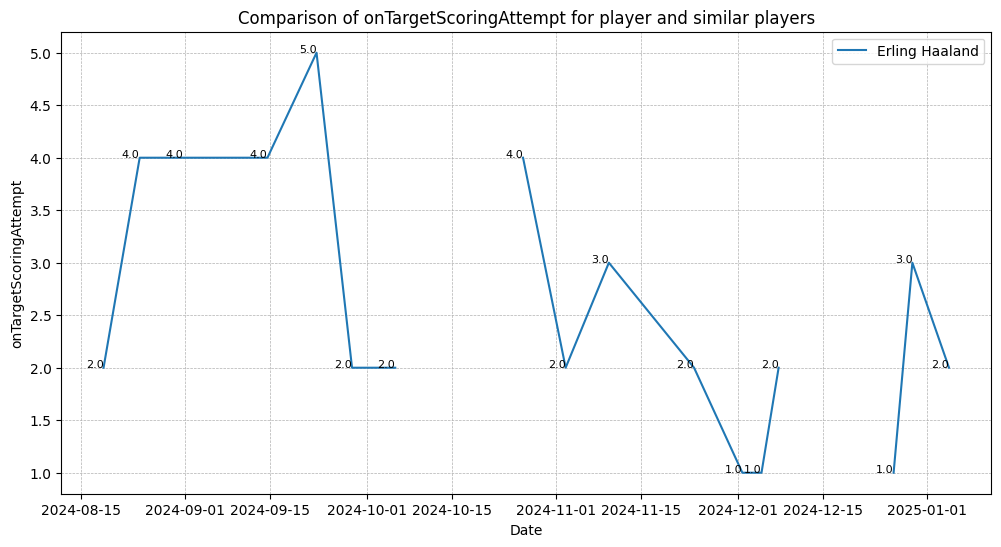

In [8]:
player_comp.plot_comparison('onTargetScoringAttempt', {}, 'Erling Haaland')

In [ ]:
pd.pivot_table(player_stats, index='homeTeam', values='onTargetScoringAttempt', aggfunc='mean')

In [ ]:
similar_player_data['Bukayo Saka']

In [ ]:
def custom_agg_func(x):
    return x.mean()/x.sum()

pd.pivot_table(player_stats, index='homeTeam', values=['onTargetScoringAttempt', 'blockedScoringAttempt', 'totalLongBalls'], aggfunc=custom_agg_func)

# pd.pivot_table(player_stats, index='homeTeam', values='onTargetScoringAttempt', aggfunc='min')

In [34]:
player_stats.loc[player_stats['homeTeam'] == 'Napoli', 'fixture_type'] = 'Home'
player_stats.loc[player_stats['awayTeam'] == 'Napoli', 'fixture_type'] = 'Away'